In [5]:
# Real life data

import logging
import json
import threading
import itertools
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor,
                                 Standard_Scaler, Robust_Scaler, MinMax_Scaler)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [6]:
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-06-30T16:08:46.556 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [3]:
#con = db.connection.connect()
DB2ConnString = 'DATABASE=' + credentials['db2']['databaseName'] + \
                ';HOSTNAME=' + credentials['db2']['host'] + \
                ';PORT=' + str(credentials['db2']['port']) + \
                ';PROTOCOL=TCPIP;UID=' + credentials['db2']['username'] + \
                ';PWD=' + credentials['db2']['password']
            
db_connection = ibm_db.connect(DB2ConnString, '', '')


# db.model = DBModelStore(credentials['tenantId'], None, credentials['db2']['username'], db.connection.connect(), 'db2'  )

In [4]:
model_store = DBModelStore(credentials['tenantId'], "TESTENTITYID", credentials['db2']['username'], db_connection, 'db2')
db.model_store = model_store

In [5]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']','').replace('\"', ''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [6]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000


#### Pandas Profiling

Try Pandas Profiling to get an overview about the data, mostly its distributions and correlations
<br>


In [7]:
# df_input[['accel_power_0','accel_anomaly']].head(20)

# removed 'rms'
#features=['accel_speed','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4']
#df_input['rms2'] = df_input['rms']
features=['rms']
targets=['rms']
predictions=['rms_std']
predictions2=['rms_rob']

#### Customer suggested a correlation between vibration and acceleration

so let's try to predict (although correlation tests do not really indicate it)

In [8]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)
print(features, targets, predictions)

stdii = Standard_Scaler(features=features, targets=targets, predictions=predictions)
robii = MinMax_Scaler(features=features, targets=targets, predictions=predictions2)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = stdii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)
et2 = robii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)

stdii._entity_type = et
robii._entity_type = et2

# allow training and delete existing models
stdii.auto_train = True
stdii.delete_existing_models = True
robii.auto_train = True
robii.delete_existing_models = True

df_input = stdii.execute(df=df_input)

2020-06-24T13:08:59.152 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
['rms'] ['rms'] ['rms_std']
2020-06-24T13:08:59.155 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-06-24T13:08:59.156 DEBUG iotfunctions.util.__init__ Starting trace
2020-06-24T13:08:59.157 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_Standard_Scaler_20200624110859
2020-06-24T13:08:59.160 DEBUG iotfunctions.util.__init__ auto_save None
2020-06-24T13:08:59.160 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-06-24T13:08:59.161 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-24T13:08:59.162 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_STANDARD_SCALER
Functions:
Granularities:
No schedules metadata
2020

In [9]:
df_input = robii.execute(df=df_input)

2020-06-24T13:09:15.838 DEBUG mmfunctions.anomaly.execute ['04714B6046D5']
2020-06-24T13:09:15.870 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_MINMAX_SCALER.MinMax_Scaler.rms.04714B6046D5']
2020-06-24T13:09:16.422 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_MINMAX_SCALER.MinMax_Scaler.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-24T13:09:16.424 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-06-24T13:09:17.642 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_MINMAX_SCALER.MinMax_Scaler.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-24T13:09:17.644 INFO iotfunctions.base.get_models_for_training load model None
2020-06-24T13:09:17.646 INFO iotfunctions.base.get_models_for_training training required: True  results: Training required because there is no existing model
2020-06-24T13:09:17.649 DEBUG iotfunctions.pip

[]

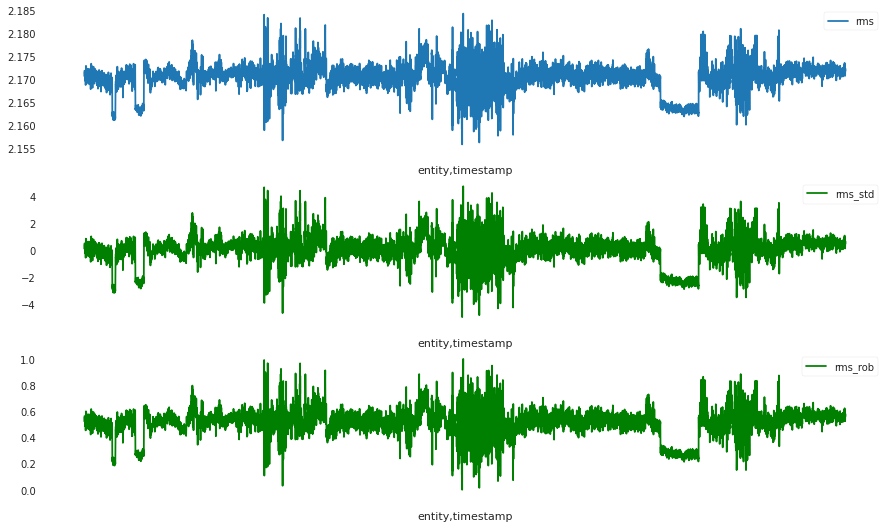

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 9))
df_input.plot(ax=ax[0], y='rms')
df_input.plot(ax=ax[1], y='rms_std', color='green')
df_input.plot(ax=ax[2], y='rms_rob', color='green')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])

In [28]:
df_input['rms'] = df_input['accel_speed']

In [32]:
predictions3 = ['rms_std']
stdii2 = Standard_Scaler(features=features, targets=targets, predictions=predictions3)
stdii2.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = stdii2._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                        Column('vibrations',Float())], **jobsettings)
stdii2._entity_type = et

# disallow training and preserve existing models for predict
stdii2.auto_train = False
stdii2.delete_existing_models = False
df_input = stdii2.execute(df=df_input)

2020-06-24T13:31:49.597 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-06-24T13:31:49.598 DEBUG iotfunctions.util.__init__ Starting trace
2020-06-24T13:31:49.598 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_Standard_Scaler_20200624113149
2020-06-24T13:31:49.599 DEBUG iotfunctions.util.__init__ auto_save None
2020-06-24T13:31:49.599 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-06-24T13:31:49.600 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-24T13:31:49.600 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_STANDARD_SCALER
Functions:
Granularities:
No schedules metadata
2020-06-24T13:31:49.602 DEBUG mmfunctions.anomaly.execute ['04714B6046D5']
2020-06-24T13:31:49.609 INFO iotfunctions.base.get_models_for_training predicting ta

In [33]:
df_input

vibrations          rms  accel_speed  \
entity       timestamp                                                       
04714B6046D5 2020-01-01 00:02:25.928    3.787826  2316.566425  2316.566425   
             2020-01-01 00:07:26.074    3.776503  2316.566425  2316.566425   
             2020-01-01 00:12:25.663    3.715573  2316.566425  2316.566425   
             2020-01-01 00:17:26.020    3.765538  2316.566425  2316.566425   
             2020-01-01 00:22:25.727    3.725934  2316.566425  2316.566425   
...                                          ...          ...          ...   
             2020-01-31 11:39:23.476    3.725156  2318.802493  2318.802493   
             2020-01-31 11:44:23.497    3.766786  2318.802493  2318.802493   
             2020-01-31 11:49:23.443    3.737750  2318.802493  2318.802493   
             2020-01-31 11:54:23.499    3.771797  2318.802493  2318.802493   
             2020-01-31 11:59:23.501    3.758436  2318.802493  2318.802493   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2904         2.2824   
             2020-01-01 00:07:26.074         2.2822         2.2978   
             2020-01-01 00:12:25.663         2.2718         2.2908   
             2020-01-01 00:17:26.020         2.2748         2.2932   
             2020-01-01 00:22:25.727         2.3320         2.2980   
...                                             ...            ...   
             2020-01-31 11:39:23.476         2.2778         2.2798   
             2020-01-31 11:44:23.497         2.2734         2.2704   
             2020-01-31 11:49:23.443         2.2666         2.2714   
             2020-01-31 11:54:23.499         2.2722         2.2738   
             2020-01-31 11:59:23.501         2.2760         2.2716   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2858         2.2956   
             2020-01-01 00:07:26.074         2.2966         2.3504   
             2020-01-01 00:12:25.663         2.2912         2.3044   
             2020-01-01 00:17:26.020         2.2926         2.3146   
             2020-01-01 00:22:25.727         2.2998         2.3212   
...                                             ...            ...   
             2020-01-31 11:39:23.476         2.2676         2.2718   
             2020-01-31 11:44:23.497         2.2694         2.2728   
             2020-01-31 11:49:23.443         2.2712         2.2690   
             2020-01-31 11:54:23.499         2.2694         2.2704   
             2020-01-31 11:59:23.501         2.2678         2.2760   

                                      accel_power_4        rms_std   rms_rob  \
entity       timestamp                                                         
04714B6046D5 2020-01-01 00:02:25.928         2.3278  791999.504821  0.563303   
             2020-01-01 00:07:26.074         2.3190  791999.504821  0.519992   
             2020-01-01 00:12:25.663         2.3232  791999.504821  0.549146   
             2020-01-01 00:17:26.020         2.3606  791999.504821  0.556316   
             2020-01-01 00:22:25.727         2.2860  791999.504821  0.518315   
...                                             ...            ...       ...   
             2020-01-31 11:39:23.476         2.2668  792764.700042  0.553155   
             2020-01-31 11:44:23.497         2.2670  792764.700042  0.524642   
             2020-01-31 11:49:23.443         2.2646  792764.700042  0.551192   
             2020-01-31 11:54:23.499         2.2650  792764.700042  0.580579   
             2020-01-31 11:59:23.501         2.2744  792764.700042  0.561302   

                                     rms_std2  
entity       timestamp                         
04714B6046D5 2020-01-01 00:02:25.928     None  
             202

[]

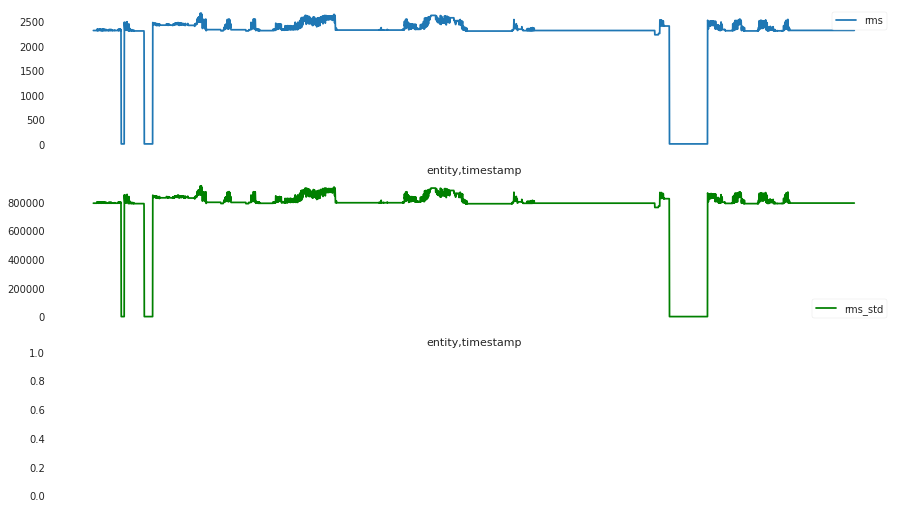

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(15, 9))
df_input.plot(ax=ax[0], y='rms')
df_input.plot(ax=ax[1], y='rms_std', color='green')
#df_input.plot(ax=ax[2], y='rms_std2', color='green')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])

In [15]:
# Run Monitoring's anomaly detector functions
# EngineLogging.configure_console_logging(logging.DEBUG)

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# allow training and delete existing models
simpleii.auto_train = True
simpleii.delete_existing_models = True
df_input = simpleii.execute(df=df_input)

2020-03-30T19:17:29.485 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:17:29.494 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5']
2020-03-30T19:17:29.981 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:29.984 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:17:30.782 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:30.783 INFO iotfunctions.base.get_models_for_training load model None
2020-03-30T19:17:30.784 INFO iotfunctions.base.get_models_for_training training r

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:34.760 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:34.761 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
2020-03-30T19:17:35.555 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:35.558 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_p

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:42.701 INFO iotfunctions.base.find_best_model Trained model no: 0
2020-03-30T19:17:42.748 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.5410548785172714
2020-03-30T19:17:42.762 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:42.775 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:47.517 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity of size 928905 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:47.518 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity
2020-03-30T19:17:58.372 INFO iotfunctions.dbtables.retrieve_model Mo

In [16]:

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# disallow training and preserve existing models for predict
simpleii.auto_train = False
simpleii.delete_existing_models = False
df_input = simpleii.execute(df=df_input)


2020-03-30T19:21:16.718 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:21:16.722 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:21:17.523 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:21:17.525 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5",
 "target": "rms",
 "features": [
  "accel_power_0",
  "accel_power_1"
 ],
 "estimator_name": "sgd_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": -1.0187012829267998,
 "eval_metric_test": -1.0230987986948104,
 "trained_date": "2020-03-30T17:17:34.254244",
 "expiry_date": null
}
2020-03-30T19:21:17.525 INFO iotfun